In [1]:
import csv
import enum
from enum import IntEnum
import datetime
import nbimporter
import SolarPosision
from SolarPosision import SolarPosision
import matplotlib.pyplot as plt

Importing Jupyter notebook from SolarPosision.ipynb


In [2]:
class enmWeatherComponent(IntEnum):
    Ta = 2     # 外気温度[℃]
    x = 6      # 絶対湿度[g/kg']
    Idn = 3    # 法線面直辰日射量[W/m2]
    Isky = 4   # 水平面天空日射量[W/m2]
    RN = 5     # 夜間放射量[W/m2]
    Ihol = 7   # 水平面全天日射量[W/m2]
    h = 8      # 太陽高度[rad]
    A = 9      # 太陽方位角[rad]

In [3]:
# 毎時気象データの所得
class Weather:

    # 気象データの取得
    def __init__(self, Lat, Lon, Ls):
        #print('Weather initialize')
        
        # 太陽位置計算クラスの作成
        self.__objSolpos = SolarPosision(Lat, Lon, Ls)
        
        # 気象データの読み込み　→　dblWdata
        with open('気象データ.csv') as f:
            reader = csv.reader(f)
            header = next(reader)
            header = next(reader)
            day = 1
            time = 1
            # データの形がVBAと違うことに注意！
            # VBAでは、dbl[5][365][24]の3次元配列。(VBなので1始まりであることに注意。)
            # ここでは、列1にday,列2にtime、列3～列7に5データを持つ2次元配列であることに注意。
            self.__dblWdata = []
            for row in reader:
                # データ自身は全部で7項目(温度、法線面直達日射量、水平面全天日射量、夜間放射量、絶対湿度)
                # このうち、VBAでは、夜間放射量と絶対湿度は捨てているので、VBAどおり、5データのみデータ化する。
                # time は、1始まりであることに注意。
                self.__dblWdata.append([day,time,float(row[2]),float(row[3]),float(row[4]),float(row[5]),float(row[6])])
                time += 1
                if time > 24 :
                    time = 1
                    day += 1
            
    # 気象データの取得
    # 戻り値はdouble
    def WeaData(self, Compnt, dtmDate, blnLinear = True):
        # Compnt:取得する気象要素
        # dtmDate:取得する日時
        # blnLinear:線形補間するかどうか（Trueは線形補間する）
        #print('WeaData')
        # 通日、時、分、秒の取得
        lngAddress = self.Address(dtmDate)
        lngMinu = dtmDate.minute
        lngSec = dtmDate.second
        
        # 線形補間時の案分比
        dblR = lngMinu / 60. + lngSec / 3600.
        
        # 1時間後のアドレスを取得
        lngAddress2 = self.Address(dtmDate + datetime.timedelta(hours = 1) )

        # 太陽位置の取得
        sp = self.__objSolpos.CalcSolpos(dtmDate)
        #print('h=', sp.dblh, 'A=', sp.dblA)
        #print(self.__dblWdata)
        #aa =  self.__dblWdata[0]
        #print(aa)
        #水平面全天日射量の場合
        if Compnt == enmWeatherComponent.Ihol:
            #正時に切り捨てた時の気象データを取得
            wdata1 = self.__dblWdata[lngAddress]
            dblIdn1 = wdata1[int(enmWeatherComponent.Idn)]
            dblIsky1 = wdata1[int(enmWeatherComponent.Isky)]
            #1時間後の気象要素を取得
            wdata2 = self.__dblWdata[lngAddress2]
            dblIdn2 = wdata2[int(enmWeatherComponent.Idn)]
            dblIsky2 = wdata2[int(enmWeatherComponent.Isky)]

            #直線補間しない場合
            if not blnLinear :
                return sp.dblSh * dblIdn2 + dblIsky2
            #直線補間する場合
            else:
                dblIdn = (1. - dblR) * dblIdn1 + dblR * dblIdn2
                dblIsky = (1. - dblR) * dblIsky1 + dblR * dblIsky2
                return typSolpos.dblSh * dblIdn + dblIsky
        #太陽高度の場合
        elif Compnt == enmWeatherComponent.h :
            return sp.dblh
        #太陽方位角の場合
        elif Compnt == enmWeatherComponent.A :
            return sp.dblA
        #上記以外の場合
        else:
            #正時に切り捨てた時の気象データを取得
            wdata1 = self.__dblWdata[lngAddress]
            dblTemp1 = wdata1[int(Compnt)]
            #1時間後の気象要素を取得
            wdata2 = self.__dblWdata[lngAddress2]
            dblTemp2 = wdata2[int(Compnt)]
            
            #print(dblR, dblTemp1, dblTemp2)
            #直線補完しない場合
            if not blnLinear :
                return dblTemp2
            #直線補間する場合
            else:
                return (1. - dblR) * dblTemp1 + dblR * dblTemp2
    
    #太陽位置の取得（計算も実施）
    def Solpos(self, dtmDate):
        return self.__objSolpos.CalcSolpos(dtmDate)
    
    # Date型日時から取得する通日、時刻アドレスを計算する
    # 0時を24時に変換するため
    # 補間は行わない
    def Address(self, dtmDate):
        # dtmDate は、datetime オブジェクトとする。
        lngHour = dtmDate.hour
        # 1月1日から数えて何日目にあたるのかを計算する。
        lngNday = (datetime.date(dtmDate.year, dtmDate.month, dtmDate.day) - datetime.date(dtmDate.year, 1, 1)).days + 1
        if lngHour == 0:
            lngNday = lngNday - 1
            lngHour = 24    
        if lngNday == 0:
            lngNday = 365
        return (lngNday - 1 ) * 24 + lngHour - 1

In [4]:
wdata = Weather(34.6583333333333, 133.918333333333, 135)
wdata.Address(datetime.datetime.strptime('2017/01/01 00:06:19', '%Y/%m/%d %H:%M:%S'))

8759

In [5]:
wdata.Address(datetime.datetime.strptime('2017/01/04 00:06:19', '%Y/%m/%d %H:%M:%S'))

71

In [6]:
wdata = Weather(34.6583333333333, 133.918333333333, 135)

In [7]:
dtmDate = datetime.datetime.strptime('2017/01/01 0:30:00', '%Y/%m/%d %H:%M:%S')
#print(dtmDate)
print(wdata.WeaData(enmWeatherComponent.Ta, dtmDate, True))

2.45


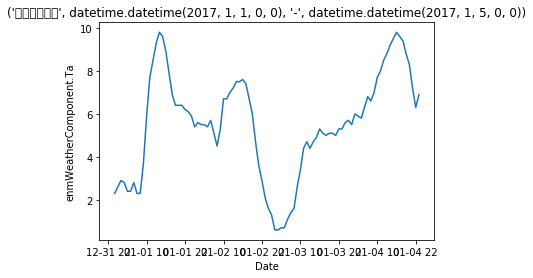

In [9]:
dtmStDate = datetime.datetime(2017, 1, 1)
dtmEnDate = datetime.datetime(2017, 1, 5)

wdt = []
xaxis = []
title = '気象データ：', dtmStDate, '-', dtmEnDate
# X軸の値を用意
for i in range((dtmEnDate - dtmStDate).days):
    for t in range(24):
        dtmplot = dtmStDate + datetime.timedelta(days = i) + datetime.timedelta(hours = t)
        xaxis.append(dtmplot)
        #print(dtmplot)
        wdt.append(wdata.WeaData(enmWeatherComponent.Ta, dtmplot, True))

# 単位貫流応答のグラフ描画
plt.plot( xaxis, wdt)
plt.title( title )
plt.xlabel('Date')
plt.ylabel(enmWeatherComponent.Ta)
#plt.legend()
plt.show()